# Word2Vec + LSTM

# Instalación de librerias

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Cargar el Corpus

In [2]:
df = pd.read_csv("../input/datos01/datos.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8918 entries, 0 to 8917
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   desp_clean_final  8901 non-null   object
 1   INCIBE TAXONOMY   8918 non-null   object
dtypes: object(2)
memory usage: 139.5+ KB


In [4]:
df.head()

,desp_clean_final,INCIBE TAXONOMY
0,compani websit breach sometim around februari ...,HC
1,decemb 29 2011 theft laptop park car san franc...,DL
2,bdo contract rubio perform financi audit servi...,DL
3,februari 10 2012 dhi mortgag becam awar softwa...,HC
4,offic burglari new year eve 2011 result loss h...,DL


In [5]:
print(len(df))

8918


In [6]:
df1 = df.dropna(axis='index',how='any') 

In [7]:
print(len(df))
print(len(df1))

8918
8901


In [8]:
df1.head()

,desp_clean_final,INCIBE TAXONOMY
0,compani websit breach sometim around februari ...,HC
1,decemb 29 2011 theft laptop park car san franc...,DL
2,bdo contract rubio perform financi audit servi...,DL
3,februari 10 2012 dhi mortgag becam awar softwa...,HC
4,offic burglari new year eve 2011 result loss h...,DL


In [9]:
labels = sorted(df1['INCIBE TAXONOMY'].unique())
labels

['DL', 'DOI', 'HC', 'OTHERS', 'PAC', 'THEFT', 'UAI']

In [10]:
df1['INCIBE TAXONOMY'].value_counts() #datos desbalaneceados

HC        2527
DOI       1854
THEFT     1728
DL        1416
OTHERS     702
PAC        606
UAI         68
Name: INCIBE TAXONOMY, dtype: int64

# Visualizacion

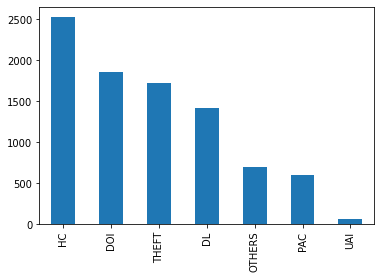

In [11]:
import matplotlib.pyplot as plt
df1['INCIBE TAXONOMY'].value_counts().plot.bar()
plt.show()

# Split Data for Train and Test


Vectorizar la descripción

In [12]:
# Maximo numero de palabras usadas
MAX_NB_WORDS = 50000
# Maximo numero de palabras en cada descripción
MAX_SEQUENCE_LENGTH = 300
# La dimensión del embeding
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['desp_clean_final'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13616 unique tokens.


In [13]:
print(word_index)

{'inform': 1, 'breach': 2, 'number': 3, 'secur': 4, 'name': 5, 'locat': 6, 'employe': 7, 'social': 8, 'address': 9, 'access': 10, 'card': 11, 'may': 12, 'patient': 13, 'data': 14, 'custom': 15, 'includ': 16, 'date': 17, 'theft': 18, 'person': 19, 'contain': 20, 'unauthor': 21, 'account': 22, 'email': 23, 'affect': 24, 'credit': 25, 'comput': 26, 'record': 27, 'offic': 28, 'use': 29, 'health': 30, 'laptop': 31, 'provid': 32, 'incid': 33, 'expos': 34, 'compani': 35, 'birth': 36, 'stolen': 37, 'servic': 38, 'medic': 39, 'system': 40, 'file': 41, 'discov': 42, 'report': 43, 'hacker': 44, 'investig': 45, 'notifi': 46, 'accessdisclosur': 47, 'student': 48, 'gener': 49, 'password': 50, 'attorney': 51, 'compromis': 52, 'former': 53, 'individu': 54, 'one': 55, 'also': 56, 'websit': 57, 'peopl': 58, 'hackingit': 59, 'payment': 60, 'state': 61, 'result': 62, 'bank': 63, 'sent': 64, 'server': 65, 'onlin': 66, 'indiana': 67, 'phone': 68, 'user': 69, 'univers': 70, 'two': 71, 'document': 72, 'curren

In [14]:
X = tokenizer.texts_to_sequences(df1['desp_clean_final'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8901, 300)


In [15]:
print(X[0:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [16]:
Y = pd.get_dummies(df1['INCIBE TAXONOMY']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (8901, 7)


In [17]:
print(Y[0:10])

[[0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [18]:
max_length=0
for descp_number in range(len(X)):
  numofwords=len(X[descp_number])
  if(numofwords)>(max_length):
    max_length = numofwords
print(max_length) 

300


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
data = pad_sequences(X, maxlen = max_length)
y = np.asarray(Y)
print(data)
print('Shape of descriptions tensor: ', data.shape)
print('Shape of label tensor: ', y.shape)

[[   0    0    0 ... 4259   54   24]
 [   0    0    0 ...  453   22    1]
 [   0    0    0 ...    8    4    3]
 ...
 [   0    0    0 ...    2    1   18]
 [   0    0    0 ...    2    1   18]
 [   0    0    0 ...    2    1   18]]
Shape of descriptions tensor:  (8901, 300)
Shape of label tensor:  (8901, 7)


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(data,y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8010, 300) (8010, 7)
(891, 300) (891, 7)


In [21]:
#import gensim.downloader as api
#w2v_model = api.load("../input/word2vec/GoogleNews-vectors-negative300.bin")

In [22]:
import tensorflow as tf
from gensim.models import KeyedVectors
from gensim import models

In [23]:
word2vec_path = '../input/word2vec/GoogleNews-vectors-negative300.bin'
w2v_model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [24]:
unique_words = len(word_index)
total_words = unique_words+1
skipped_words = 0
embedding_dim = 300
embedding_matrix = np.zeros((total_words,embedding_dim))
for word, index in tokenizer.word_index.items():
  try:
    embedding_vector = w2v_model[word]
  except:
    skipped_words = skipped_words+1
    pass
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
print("Embedding Matrix shape: ", embedding_matrix.shape)  

Embedding Matrix shape:  (13617, 300)


In [25]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable = False)

In [26]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Red Neuronal LSTM + capa de embedding con Word2Vec

In [27]:
# LSTM model
modelx01 = Sequential()
modelx01.add(embedding_layer)
modelx01.add(LSTM(units=300, use_bias=False, return_sequences=True))
modelx01.add(BatchNormalization())
modelx01.add(Activation('relu'))
modelx01.add(LSTM(units=200,use_bias=False, return_sequences=True))
modelx01.add(BatchNormalization())
modelx01.add(Activation('relu'))
modelx01.add(LSTM(units=100,use_bias=False, return_sequences=False))
modelx01.add(BatchNormalization())
modelx01.add(Activation('relu'))
modelx01.add(Dense(units=7, activation='softmax'))

#modelx01.compile(loss = 'mse', optimizer = 'adamax', metrics=['F1Score'])
# compile the model
#probar con esta funcion de perdida
#categorical_crossentropy 
modelx01.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx01.summary())

2022-06-01 15:56:47.328703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 15:56:47.472986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 15:56:47.473857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 15:56:47.476224: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 300)          720000    
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300)          1200      
_________________________________________________________________
activation (Activation)      (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 200)          400000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 200)          800       
_________________________________________________________________
activation_1 (Activation)    (None, 300, 200)          0

In [28]:
epochs=10
batch_size=16
#histoty_modelx01 = modelx01.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

# fit the model
history_modelx01 = modelx01.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

2022-06-01 15:56:50.735129: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
351/351 [==============================] - 550s 2s/step - loss: 0.2663 - accuracy: 0.6440 - f1_m: 0.6229 - precision_m: 0.8448 - recall_m: 0.5100 - val_loss: 0.3576 - val_accuracy: 0.2538 - val_f1_m: 0.0690 - val_precision_m: 0.3160 - val_recall_m: 0.0397
Epoch 2/10
351/351 [==============================] - 546s 2s/step - loss: 0.1661 - accuracy: 0.7771 - f1_m: 0.7685 - precision_m: 0.8579 - recall_m: 0.7011 - val_loss: 0.1585 - val_accuracy: 0.7840 - val_f1_m: 0.7794 - val_precision_m: 0.8480 - val_recall_m: 0.7246
Epoch 3/10
351/351 [==============================] - 550s 2s/step - loss: 0.1333 - accuracy: 0.8215 - f1_m: 0.8220 - precision_m: 0.8734 - recall_m: 0.7793 - val_loss: 0.1433 - val_accuracy: 0.7928 - val_f1_m: 0.7965 - val_precision_m: 0.8312 - val_recall_m: 0.7664
Epoch 4/10
351/351 [==============================] - 553s 2s/step - loss: 0.1141 - accuracy: 0.8557 - f1_m: 0.8572 - precision_m: 0.8927 - recall_m: 0.8264 - val_loss: 0.1314 - val_accuracy: 0.8194 

In [29]:
# evaluate the model
lossx01, accuracyx01, f1_scorex01, precisionx01, recallx01 = modelx01.evaluate(X_test, Y_test, verbose=1)

28/28 [==============================] - 3s 104ms/step - loss: 0.1523 - accuracy: 0.8272 - f1_m: 0.8314 - precision_m: 0.8462 - recall_m: 0.8175


In [30]:
accrx01 = modelx01.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx01[0],accrx01[1],accrx01[2],accrx01[3],accrx01[4]))

28/28 [==============================] - 3s 112ms/step - loss: 0.1523 - accuracy: 0.8272 - f1_m: 0.8314 - precision_m: 0.8462 - recall_m: 0.8175
Test set
 Loss: 0.1523
 Accuracy: 0.8272
 f1_score: 0.8314
 Precision: 0.8462
 Recall: 0.8175


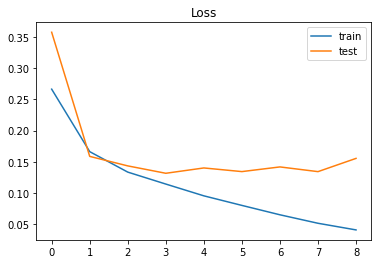

In [31]:
plt.title('Loss')
plt.plot(history_modelx01.history['loss'], label='train')
plt.plot(history_modelx01.history['val_loss'], label='test')
plt.legend()
plt.show();

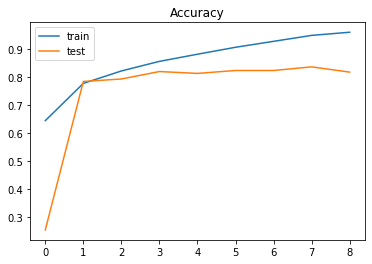

In [32]:
plt.title('Accuracy')
plt.plot(history_modelx01.history['accuracy'], label='train')
plt.plot(history_modelx01.history['val_accuracy'], label='test')
plt.legend()
plt.show();

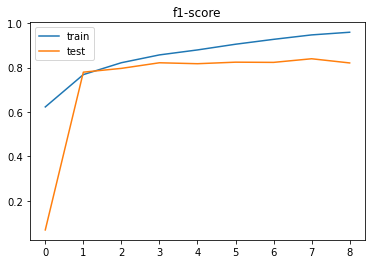

In [33]:
plt.title('f1-score')
plt.plot(history_modelx01.history['f1_m'], label='train')
plt.plot(history_modelx01.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [34]:
y_pred_01 = np.where(modelx01.predict(X_test)>.5,1,0)

Text(33.0, 0.5, 'real')

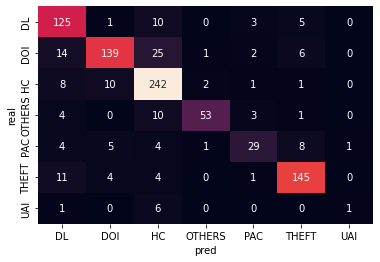

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_LSTM_W2V01= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_01).argmax(axis=1))
sns.heatmap(mat_LSTM_W2V01, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')

# Word2Vec + CNN

In [36]:
embedding_layer_cnn = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable = False)

In [37]:
# CNN model
modelx02 = Sequential()
modelx02.add(embedding_layer)

modelx02.add(Conv1D(filters=300, kernel_size=7, padding='same', activation='relu'))
modelx02.add(MaxPooling1D(pool_size=3))
modelx02.add(BatchNormalization())
modelx02.add(Activation('relu'))

modelx02.add(Conv1D(filters=100, kernel_size=7, padding='same', activation='relu'))
modelx02.add(MaxPooling1D(pool_size=2))
modelx02.add(BatchNormalization())
modelx02.add(Activation('relu'))

modelx02.add(LSTM(units=50,activation='relu',use_bias=False, return_sequences=False))

modelx02.add(Dense(units=7, activation='softmax'))

# compile the model
modelx02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx02.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 300)          630300    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100, 300)          1200      
_________________________________________________________________
activation_3 (Activation)    (None, 100, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 100)          210100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 100)          

In [38]:
epochs=10
batch_size=8
# fit the model
history_modelx02 = modelx02.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10


2022-06-01 17:21:54.999408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


701/701 [==============================] - 83s 108ms/step - loss: 0.8885 - accuracy: 0.6743 - f1_m: 0.6561 - precision_m: 0.8809 - recall_m: 0.5452 - val_loss: 0.7499 - val_accuracy: 0.7499 - val_f1_m: 0.7331 - val_precision_m: 0.8724 - val_recall_m: 0.6451
Epoch 2/10
701/701 [==============================] - 75s 106ms/step - loss: 0.5750 - accuracy: 0.8068 - f1_m: 0.7979 - precision_m: 0.8939 - recall_m: 0.7296 - val_loss: 0.6435 - val_accuracy: 0.7898 - val_f1_m: 0.7845 - val_precision_m: 0.8635 - val_recall_m: 0.7269
Epoch 3/10
701/701 [==============================] - 76s 108ms/step - loss: 0.3837 - accuracy: 0.8730 - f1_m: 0.8675 - precision_m: 0.9186 - recall_m: 0.8274 - val_loss: 0.9301 - val_accuracy: 0.7736 - val_f1_m: 0.7790 - val_precision_m: 0.8342 - val_recall_m: 0.7364
Epoch 4/10
701/701 [==============================] - 79s 112ms/step - loss: 0.3705 - accuracy: 0.8791 - f1_m: 0.8730 - precision_m: 0.9194 - recall_m: 0.8363 - val_loss: 0.7280 - val_accuracy: 0.7919 - v

In [39]:
# evaluate the model
lossx02, accuracyx02, f1_scorex02, precisionx02, recallx02 = modelx02.evaluate(X_test, Y_test, verbose=1)

28/28 [==============================] - 0s 10ms/step - loss: 0.7889 - accuracy: 0.7946 - f1_m: 0.7994 - precision_m: 0.8492 - recall_m: 0.7560


In [40]:
accrx02 = modelx02.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx02[0],accrx02[1],accrx02[2],accrx02[3],accrx02[4]))

28/28 [==============================] - 0s 11ms/step - loss: 0.7889 - accuracy: 0.7946 - f1_m: 0.7994 - precision_m: 0.8492 - recall_m: 0.7560
Test set
 Loss: 0.7889
 Accuracy: 0.7946
 f1_score: 0.7994
 Precision: 0.8492
 Recall: 0.7560


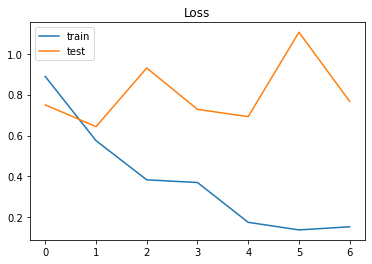

In [41]:
plt.title('Loss')
plt.plot(history_modelx02.history['loss'], label='train')
plt.plot(history_modelx02.history['val_loss'], label='test')
plt.legend()
plt.show();

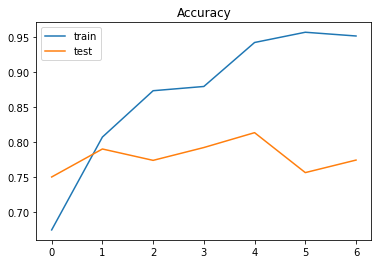

In [42]:
plt.title('Accuracy')
plt.plot(history_modelx02.history['accuracy'], label='train')
plt.plot(history_modelx02.history['val_accuracy'], label='test')
plt.legend()
plt.show();

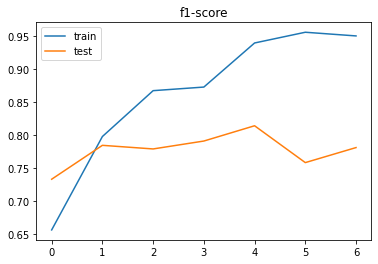

In [43]:
plt.title('f1-score')
plt.plot(history_modelx02.history['f1_m'], label='train')
plt.plot(history_modelx02.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [44]:
y_pred_02 = np.where(modelx02.predict(X_test)>.5,1,0)

In [45]:
from sklearn import metrics
print(metrics.classification_report(y_pred_02, Y_test))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       124
           1       0.65      0.88      0.75       137
           2       0.83      0.85      0.84       255
           3       0.77      0.89      0.83        62
           4       0.42      0.71      0.53        31
           5       0.88      0.80      0.84       182
           6       0.12      0.50      0.20         2

   micro avg       0.76      0.85      0.80       793
   macro avg       0.64      0.79      0.69       793
weighted avg       0.78      0.85      0.81       793
 samples avg       0.76      0.76      0.76       793



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'real')

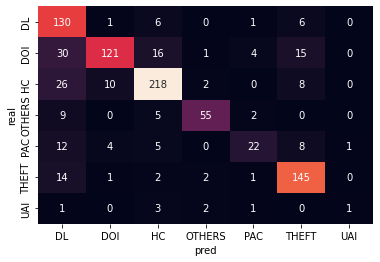

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_LSTM_W2V02= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_02).argmax(axis=1))
sns.heatmap(mat_LSTM_W2V02, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')

In [47]:
#pip freeze (versiones)